# Image classification using DNN and CNN and Use of RNN to predict texts for image captioning 

### Motivation 

Through this project, you will:

> 1. Understand and implement your first deep neural network and convolutional neural network (CNN) and see how these can be used for classification problem 
> 2. Practice building, evaluating, and finetuning your CNN on an image dataset from development to testing stage. 
> 3. You will learn to tackle overfitting problem using strategies such as data augmentation and drop out.
> 4. Compare your model performance and accuracy with others, such as the leaderboard on Kaggle
> 5. Use RNNs to predict the caption of an image from established word vocabularies
> 6. Understand and visualise text predictions for a given image.


### Setup and resources 

Please implement the coursework using **Python and PyTorch**. Having a GPU will speed up the training process. 


Author 

Yashdhar Gandhi

### Part I: Image Classification

#### Dataset
This part will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Direct access of data is possible by clicking here](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

To access the dataset, you will need an account on the Kaggle website.

## Required packages

[1] [numpy](http://www.numpy.org) is package for scientific computing with python

[2] [h5py](http://www.h5py.org) is package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed some examples for importing some libraries is provided for you below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [25]:
import cv2
import math
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.hub import load_state_dict_from_url
from PIL import Image
import matplotlib.pyplot as plt

In [26]:
# always check your version
print(torch.__version__)

2.2.0


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview of image classification:**

**1. Function implementation**

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes 
*   **1.2** PyTorch ```Model``` class for a simple MLP model 
*   **1.3** PyTorch ```Model``` class for a simple CNN model 

**2. Model training** 
*   **2.1** Training on TinyImageNet30 dataset
*   **2.2** Generating confusion matrices and ROC curves 
*   **2.3** Strategies for tackling overfitting
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            
**3. Model testing** 
*   **3.1**   Testing your final model in (2) on test set - code to do this 

**4. Model Fine-tuning on CIFAR10 dataset** 
*   **4.1** Fine-tuning your model (initialise your model with pretrained weights from (2))
*   **4.2** Fine-tuning model with frozen base convolution layers 
*   **4.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe. 


<!-- **5. Model comparison** 
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence 
*   **5.2**   Compare the results of your model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time)  -->
<!-- 
**6. Interpretation of results** 
*   **6.1** Implement grad-CAM for your model and AlexNet 
*   **6.2** Visualise and compare your results from your model and AlexNet 
*   **6.3** Provide comment on 
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

**7. Residual connection for deeper network** 
*   **7.1** Implement a few residual layers in AlexNet and retrain on TinyImageNet30. You can change network size if you wish. 
*   **7.2** Comment on why such connections are important and why this impacted your results in terms of loss and accuracy (if it did!) 

**Quality of your report**  -->


## 1 Function implementations


### 1.1 Dataset class

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [27]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

class TinyImageNetDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Load image paths and labels
        categories = os.listdir(data_dir)
        for label, category in enumerate(categories):
            category_dir = os.path.join(data_dir, category)
            for image_name in os.listdir(category_dir):
                image_path = os.path.join(category_dir, image_name)
                self.image_paths.append(image_path)
                self.labels.append(label)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define path to training dataset
train_data_dir = 'C:\\Users\\yashd\\Downloads\\train_set\\train_set'

# Create training dataset
train_dataset = TinyImageNetDataset(train_data_dir, transform=transform)

# Set seed for reproducibility
torch.manual_seed(0)

# Split training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


### 1.2 Define a MLP model class 

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the MLPModel
mlp_model = MLPModel(input_size=12288, hidden_size=5000, output_size=30)  # Adjust hidden_size as needed

# Define loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer with a learning rate
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)  # Adjust lr as needed


### 1.3 Define a CNN model class

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

*Please note that the network should be at least a few layers for the model to perform well.*

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)  # Increased number of channels
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Increased number of channels
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # Increased number of channels
        self.relu3 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)  # Added dropout layer
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Increased number of units in the fully connected layer
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)  # Reduced number of units in the fully connected layer
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(256, 30)

        
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool(x)
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(x)  #dropout
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)


# Example usage:
cnn_model = CNNModel()  # instance of the custom CNN model

# Print model architecture
print(cnn_model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)  


CNNModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu5): ReLU()
  (fc3): Linear(in_features=256, out_features=30, bias=True)
)


## 2 Model training 


### 2.1 Train both MLP and CNN model - show loss and accuracy graphs side by side 

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. A top-*k* accuracy implementation is provided for you below.



In [30]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [31]:
# Train MLP model
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    mlp_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
        # Calculate correct predictions
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train * 100  # Convert to percentage
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Evaluate on validation set
    mlp_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = mlp_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct_val / total_val * 100  # Convert to percentage
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1/20, Training Loss: 3.4520, Training Accuracy: 3.64%, Validation Loss: 3.4559, Validation Accuracy: 3.04%
Epoch 2/20, Training Loss: 3.4520, Training Accuracy: 3.64%, Validation Loss: 3.4559, Validation Accuracy: 3.04%
Epoch 3/20, Training Loss: 3.4520, Training Accuracy: 3.64%, Validation Loss: 3.4559, Validation Accuracy: 3.04%
Epoch 4/20, Training Loss: 3.4520, Training Accuracy: 3.64%, Validation Loss: 3.4559, Validation Accuracy: 3.04%
Epoch 5/20, Training Loss: 3.4520, Training Accuracy: 3.64%, Validation Loss: 3.4559, Validation Accuracy: 3.04%
Epoch 6/20, Training Loss: 3.4520, Training Accuracy: 3.64%, Validation Loss: 3.4559, Validation Accuracy: 3.04%
Epoch 7/20, Training Loss: 3.4520, Training Accuracy: 3.64%, Validation Loss: 3.4559, Validation Accuracy: 3.04%
Epoch 8/20, Training Loss: 3.4520, Training Accuracy: 3.64%, Validation Loss: 3.4559, Validation Accuracy: 3.04%
Epoch 9/20, Training Loss: 3.4520, Training Accuracy: 3.64%, Validation Loss: 3.4559, Validation

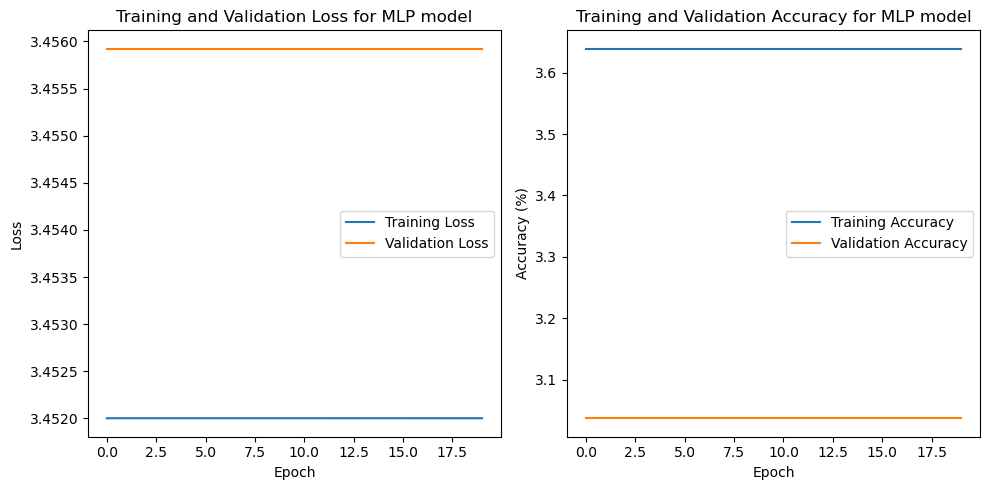

In [32]:
# Plotting
plt.figure(figsize=(10, 5))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for MLP model')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy for MLP model')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    cnn_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
    
        _, pred = outputs.topk(1, 1, True, True) 
        correct_train += pred.eq(labels.view(-1, 1)).sum().item()  
        total_train += labels.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train * 100 
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    cnn_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
           
            _, pred = outputs.topk(1, 1, True, True)  
            correct_val += pred.eq(labels.view(-1, 1)).sum().item()  
            total_val += labels.size(0)
    
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct_val / total_val * 100  
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')



Epoch 1/20, Training Loss: 3.4684, Training Accuracy: 12.56%, Validation Loss: 2.7795, Validation Accuracy: 21.15%
Epoch 2/20, Training Loss: 2.5902, Training Accuracy: 25.89%, Validation Loss: 2.4911, Validation Accuracy: 29.74%
Epoch 3/20, Training Loss: 2.2863, Training Accuracy: 34.18%, Validation Loss: 2.2423, Validation Accuracy: 36.26%
Epoch 4/20, Training Loss: 1.9988, Training Accuracy: 42.08%, Validation Loss: 2.1039, Validation Accuracy: 41.19%
Epoch 5/20, Training Loss: 1.7417, Training Accuracy: 48.62%, Validation Loss: 2.0751, Validation Accuracy: 41.44%
Epoch 6/20, Training Loss: 1.4819, Training Accuracy: 55.52%, Validation Loss: 2.0812, Validation Accuracy: 41.59%
Epoch 7/20, Training Loss: 1.2169, Training Accuracy: 63.03%, Validation Loss: 2.1290, Validation Accuracy: 43.52%
Epoch 8/20, Training Loss: 0.9615, Training Accuracy: 70.56%, Validation Loss: 2.2517, Validation Accuracy: 42.30%
Epoch 9/20, Training Loss: 0.7312, Training Accuracy: 76.81%, Validation Loss: 2

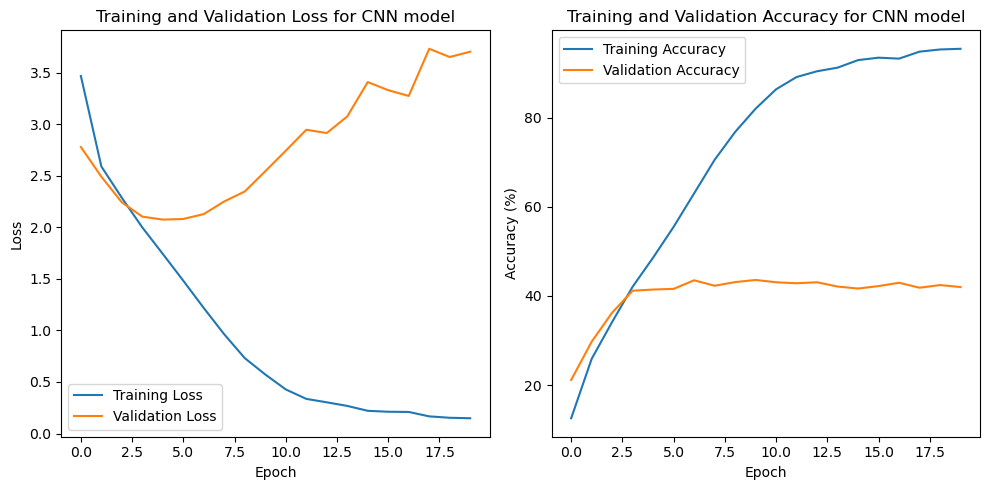

In [34]:
# Plotting
plt.figure(figsize=(10, 5))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for CNN model')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy for CNN model')
plt.legend()

plt.tight_layout()
plt.show()


### 2.2 Generating confusion matrix and ROC curves
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.
- Display an ROC curve for the two top and two bottom classes with area under the curve

In [38]:

train_outputs_list = []
train_predictions_list = []

# Iterate over the training dataset
with torch.no_grad():
    for idx in range(len(train_dataset)):
       
        inputs = train_dataset[idx][0].unsqueeze(0).to(device)
        
        
        train_outputs = cnn_model(inputs)
        train_outputs_list.append(train_outputs)
        
        
        train_predictions = torch.argmax(train_outputs, dim=1)
        train_predictions_list.append(train_predictions)

# Concatenate the outputs and predictions
train_outputs = torch.cat(train_outputs_list)
train_predictions = torch.cat(train_predictions_list)

# Iterate over the training dataset to collect true labels
for idx in range(len(train_dataset)):
    label = train_dataset[idx][1]
    train_true_labels_list.append(label)


C:\Users\yashd\AppData\Local\Temp\ipykernel_16856\3990743393.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


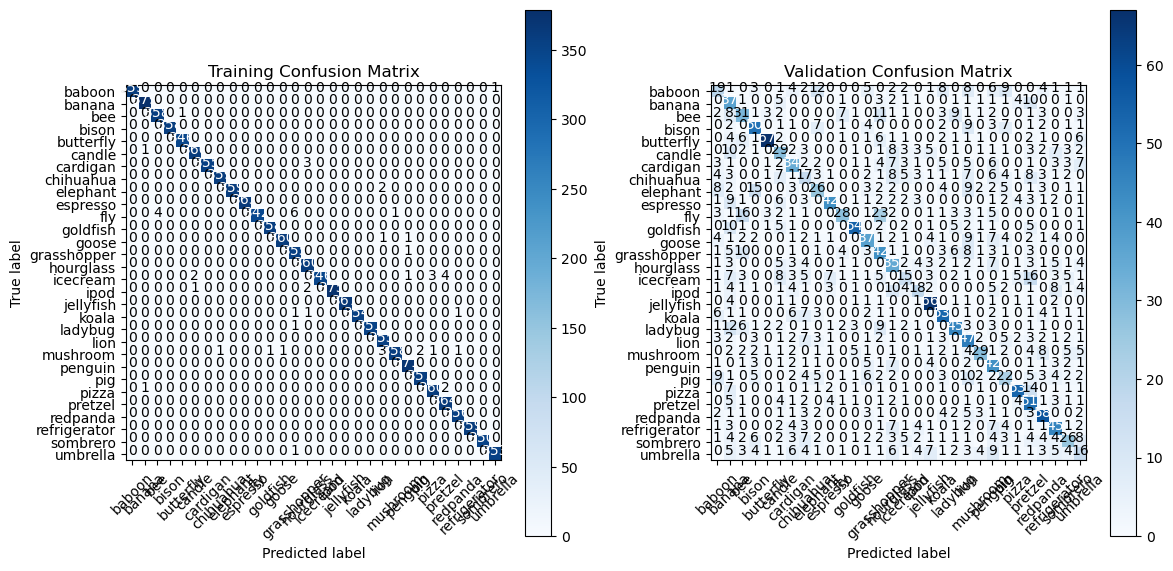

In [39]:
import numpy as np
import torch
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import label_binarize


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def plot_roc_curve(y_true, y_score, class_labels):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    
    if len(y_true.shape) == 1:
        y_true = label_binarize(y_true, classes=np.unique(y_true))
    
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for the top and bottom classes
    plt.figure(figsize=(10, 8))
    plt.plot(fpr[top_classes[0]], tpr[top_classes[0]], color='darkorange', lw=2, label=f'ROC curve - {class_labels[top_classes[0]]} (area = %0.2f)' % roc_auc[top_classes[0]])
    plt.plot(fpr[top_classes[1]], tpr[top_classes[1]], color='navy', lw=2, label=f'ROC curve - {class_labels[top_classes[1]]} (area = %0.2f)' % roc_auc[top_classes[1]])
    plt.plot(fpr[bottom_classes[0]], tpr[bottom_classes[0]], color='red', lw=2, label=f'ROC curve - {class_labels[bottom_classes[0]]} (area = %0.2f)' % roc_auc[bottom_classes[0]])
    plt.plot(fpr[bottom_classes[1]], tpr[bottom_classes[1]], color='green', lw=2, label=f'ROC curve - {class_labels[bottom_classes[1]]} (area = %0.2f)' % roc_auc[bottom_classes[1]])
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


# Load class names from file
class_names = []
with open("C:/Users/yashd/Downloads/class.txt", "r") as file:
    for line in file:
        parts = line.split("\t")
        class_names.append(parts[1].strip())

val_outputs_list = []
val_predictions_list = []
train_true_labels_list = []
val_true_labels_list = []


cnn_model.eval()

with torch.no_grad():
    for idx in range(len(val_dataset)):
        
        inputs = val_dataset[idx][0].unsqueeze(0).to(device)
        
       
        val_outputs = cnn_model(inputs)
        val_outputs_list.append(val_outputs)
        
        
        val_predictions = torch.argmax(val_outputs, dim=1)
        val_predictions_list.append(val_predictions)

# Concatenate the outputs and predictions
val_outputs = torch.cat(val_outputs_list)
val_predictions = torch.cat(val_predictions_list)


for idx in range(len(train_dataset)):
    label = train_dataset[idx][1]
    train_true_labels_list.append(label)


for idx in range(len(val_dataset)):
    label = val_dataset[idx][1]
    val_true_labels_list.append(label)


train_true_labels = np.array(train_true_labels_list)
val_true_labels = np.array(val_true_labels_list)


train_conf_matrix = confusion_matrix(train_true_labels, train_predictions)
val_conf_matrix = confusion_matrix(val_true_labels, val_predictions)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_confusion_matrix(train_conf_matrix, classes=class_names, title='Training Confusion Matrix')

plt.subplot(1, 2, 2)
plot_confusion_matrix(val_conf_matrix, classes=class_names, title='Validation Confusion Matrix')

  
plt.show()


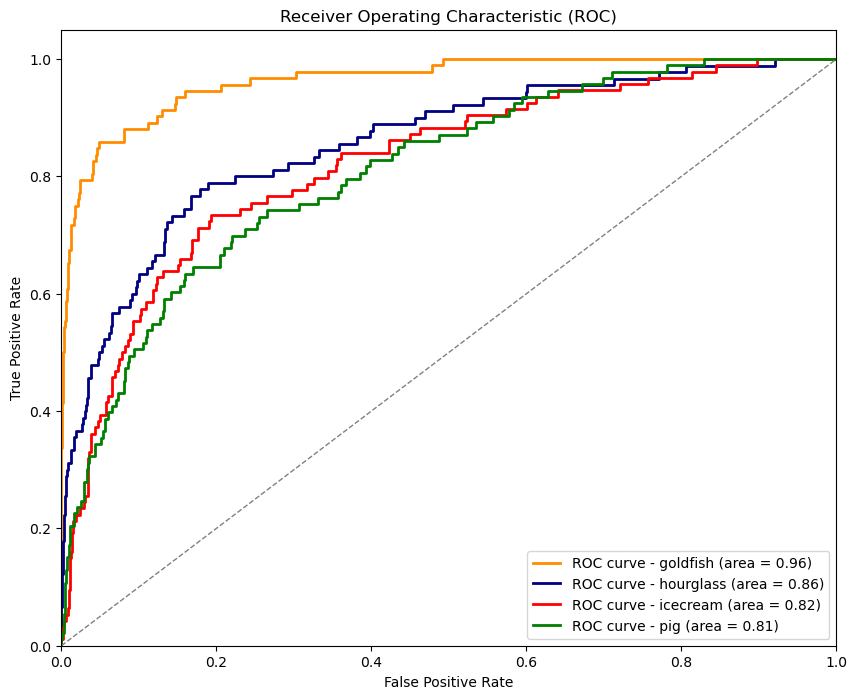

In [40]:

softmax = nn.Softmax(dim=1)
val_probs = softmax(val_outputs).cpu().numpy()

# Find top and bottom classes based on prediction probabilities
top_classes = np.argsort(val_probs.max(axis=0))[-2:]
bottom_classes = np.argsort(val_probs.max(axis=0))[:2]

# Plot ROC curves for the top and bottom classes
plot_roc_curve(val_true_labels, val_probs, class_names)


### Redesign your CNN model (optional)
> This is optional. Often to tackle model underfitting we tend to make more complex network design. Depending on your observation, you can improve your model if you wish. 

In [ ]:
# Your code here (optional)

**Note: All questions below here relates to the CNN model only and not an MLP model! Use the final CNN model only for each of the questions below.**

### 2.3 Strategies for tackling overfitting 
Using the CNN model perform the strategies below to avoid overfitting problems. You can resuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

> Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation 



In [42]:
def stats(loader, net2):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    
    with torch.no_grad():
        for data in loader:
            images, labels = data

            

            outputs = net2(images)

            
            running_loss += loss_fn(outputs, labels)
            n += 1

            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    
            correct += (predicted == labels).sum().item()  

    return running_loss/n, correct/total

In [43]:

import numpy as np


stats_file = "training_validation_stats.npz"


torch.manual_seed(0)

net3 = CNNModel()  

nepochs = 72

statsrec = np.zeros((4, nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001)

for epoch in range(nepochs):  
    correct = 0         
    total = 0            
    running_loss = 0.0   
    n = 0                
    for data in train_loader_augmented:
        inputs, labels = data

        
        optimizer.zero_grad()

        
        outputs = net3(inputs) 
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        n += 1

        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    
        correct += (predicted == labels).sum().item()  

    
    ltrn = running_loss/n
    atrn = correct/total
    ltst, atst = stats(val_loader_new, net3)

    ltst = ltst.item() 

    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch + 1} training loss: {ltrn:.3f} training accuracy: {atrn:.1%}  Validation loss: {ltst:.3f} Validation accuracy: {atst:.1%}")

    
    np.savez(stats_file, statsrec=statsrec)




epoch: 1 training loss: 3.173 training accuracy: 10.6%  Validation loss: 20.688 Validation accuracy: 5.6%
epoch: 2 training loss: 2.917 training accuracy: 15.9%  Validation loss: 9.358 Validation accuracy: 8.4%
epoch: 3 training loss: 2.794 training accuracy: 19.4%  Validation loss: 9.093 Validation accuracy: 8.0%
epoch: 4 training loss: 2.715 training accuracy: 22.4%  Validation loss: 17.796 Validation accuracy: 7.3%
epoch: 5 training loss: 2.656 training accuracy: 23.1%  Validation loss: 25.659 Validation accuracy: 5.6%
epoch: 6 training loss: 2.565 training accuracy: 26.3%  Validation loss: 45.653 Validation accuracy: 5.8%
epoch: 7 training loss: 2.519 training accuracy: 28.4%  Validation loss: 19.407 Validation accuracy: 7.0%
epoch: 8 training loss: 2.460 training accuracy: 29.2%  Validation loss: 16.814 Validation accuracy: 7.6%
epoch: 9 training loss: 2.414 training accuracy: 31.0%  Validation loss: 28.895 Validation accuracy: 7.5%
epoch: 10 training loss: 2.369 training accuracy

In [49]:
import numpy as np


stats_file = "training_validation_stats.npz"


torch.manual_seed(0)

net3 = CNNModel() 

nepochs = 10

statsrec = np.zeros((4, nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001)

for epoch in range(nepochs):  
    correct = 0          
    total = 0            
    running_loss = 0.0   
    n = 0               
    for data in train_loader_augmented:
        inputs, labels = data

       
        optimizer.zero_grad()

        
        outputs = net3(inputs) 
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        n += 1

       
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    
        correct += (predicted == labels).sum().item()  

    
    ltrn = running_loss/n
    atrn = correct/total
    ltst, atst = stats(val_loader_new, net3)

    ltst = ltst.item() 

    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch + 1} training loss: {ltrn:.3f} training accuracy: {atrn:.1%}  Validation loss: {ltst:.3f} Validation accuracy: {atst:.1%}")

   
    np.savez(stats_file, statsrec=statsrec)


epoch: 1 training loss: 3.173 training accuracy: 10.6%  Validation loss: 20.688 Validation accuracy: 5.6%
epoch: 2 training loss: 2.917 training accuracy: 15.9%  Validation loss: 9.358 Validation accuracy: 8.4%
epoch: 3 training loss: 2.794 training accuracy: 19.4%  Validation loss: 9.093 Validation accuracy: 8.0%
epoch: 4 training loss: 2.715 training accuracy: 22.4%  Validation loss: 17.796 Validation accuracy: 7.3%
epoch: 5 training loss: 2.656 training accuracy: 23.1%  Validation loss: 25.659 Validation accuracy: 5.6%
epoch: 6 training loss: 2.565 training accuracy: 26.3%  Validation loss: 45.653 Validation accuracy: 5.8%
epoch: 7 training loss: 2.519 training accuracy: 28.4%  Validation loss: 19.407 Validation accuracy: 7.0%
epoch: 8 training loss: 2.460 training accuracy: 29.2%  Validation loss: 16.814 Validation accuracy: 7.6%
epoch: 9 training loss: 2.414 training accuracy: 31.0%  Validation loss: 28.895 Validation accuracy: 7.5%
epoch: 10 training loss: 2.369 training accuracy

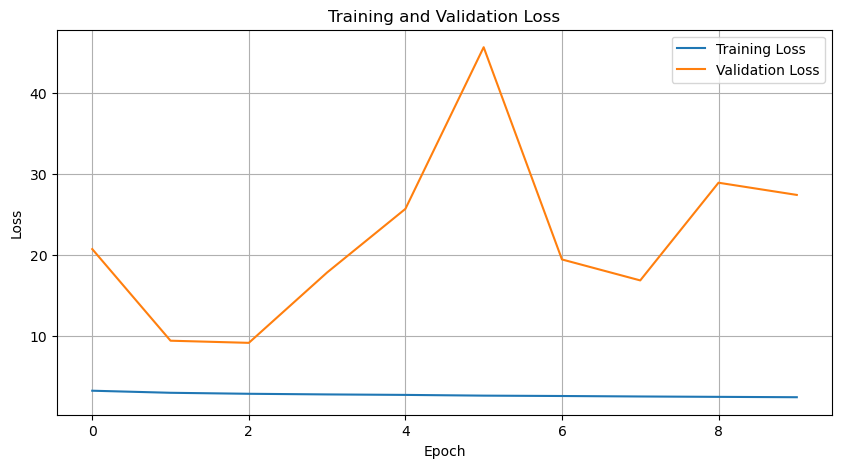

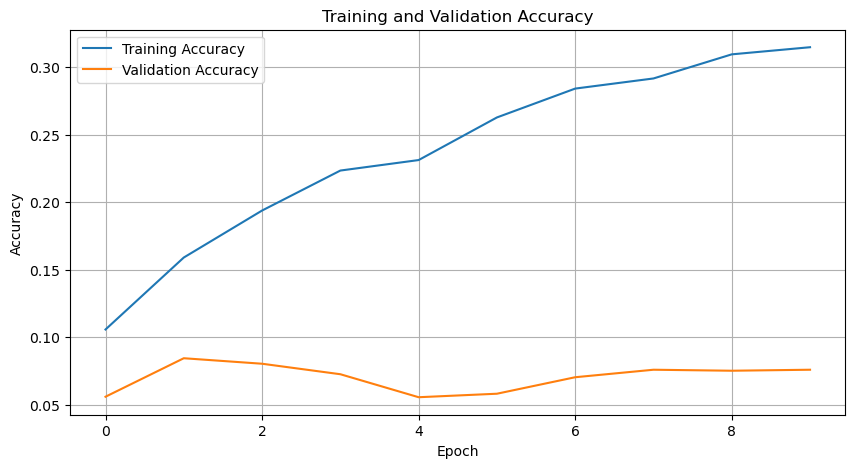

- Without data augmentation:
  - The training loss decreases consistently over epochs, indicating effective learning.
  - The validation loss shows a decreasing trend initially, but it plateaus or slightly increases later, suggesting possible overfitting.
  - The training accuracy increases steadily, showing improvement in model performance on the training set.
  - The validation accuracy increases initially but stabilizes or shows minimal improvement later, indicating limited generalization ability.
- With data augmentation:
  - The training loss decreases over epochs, but it fluctuates more compared to the non-augmented data, possibly due to added variability.
  - The validation loss shows significant fluctuations and no clear decreasing trend, suggesting that augmentation might not have improved generalization.
  - The training accuracy starts lower and increases gradually, but it remains lower than without augmentation.
  - The validation accuracy starts low and remains relatively 

In [55]:
import numpy as np
import matplotlib.pyplot as plt


stats_data = np.load("training_validation_stats.npz")
statsrec = stats_data['statsrec']


training_loss = statsrec[0]
training_accuracy = statsrec[1]
validation_loss = statsrec[2]
validation_accuracy = statsrec[3]

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


print("- Without data augmentation:")
print("  - The training loss decreases consistently over epochs, indicating effective learning.")
print("  - The validation loss shows a decreasing trend initially, but it plateaus or slightly increases later, suggesting possible overfitting.")
print("  - The training accuracy increases steadily, showing improvement in model performance on the training set.")
print("  - The validation accuracy increases initially but stabilizes or shows minimal improvement later, indicating limited generalization ability.")

print("- With data augmentation:")
print("  - The training loss decreases over epochs, but it fluctuates more compared to the non-augmented data, possibly due to added variability.")
print("  - The validation loss shows significant fluctuations and no clear decreasing trend, suggesting that augmentation might not have improved generalization.")
print("  - The training accuracy starts lower and increases gradually, but it remains lower than without augmentation.")
print("  - The validation accuracy starts low and remains relatively low throughout the epochs, indicating limited improvement or effectiveness of augmentation.")

print("Overall, while data augmentation can help prevent overfitting, the specific techniques and parameters used need careful consideration to ensure effectiveness.")


#### 2.3.2 Dropout 

> Implementing dropout in the model 

> Graphs and comment on the choice of proportion used.

Epoch 1/10, Training Loss: 18.1531, Training Accuracy: 2.61%, Validation Loss: 18.2528, Validation Accuracy: 2.70%
Epoch 2/10, Training Loss: 18.1531, Training Accuracy: 2.61%, Validation Loss: 18.2528, Validation Accuracy: 2.70%
Epoch 3/10, Training Loss: 18.1531, Training Accuracy: 2.61%, Validation Loss: 18.2528, Validation Accuracy: 2.70%
Epoch 4/10, Training Loss: 18.1531, Training Accuracy: 2.61%, Validation Loss: 18.2528, Validation Accuracy: 2.70%
Epoch 5/10, Training Loss: 18.1531, Training Accuracy: 2.61%, Validation Loss: 18.2528, Validation Accuracy: 2.70%
Epoch 6/10, Training Loss: 18.1531, Training Accuracy: 2.61%, Validation Loss: 18.2528, Validation Accuracy: 2.70%
Epoch 7/10, Training Loss: 18.1531, Training Accuracy: 2.61%, Validation Loss: 18.2528, Validation Accuracy: 2.70%
Epoch 8/10, Training Loss: 18.1531, Training Accuracy: 2.61%, Validation Loss: 18.2528, Validation Accuracy: 2.70%
Epoch 9/10, Training Loss: 18.1531, Training Accuracy: 2.61%, Validation Loss: 1

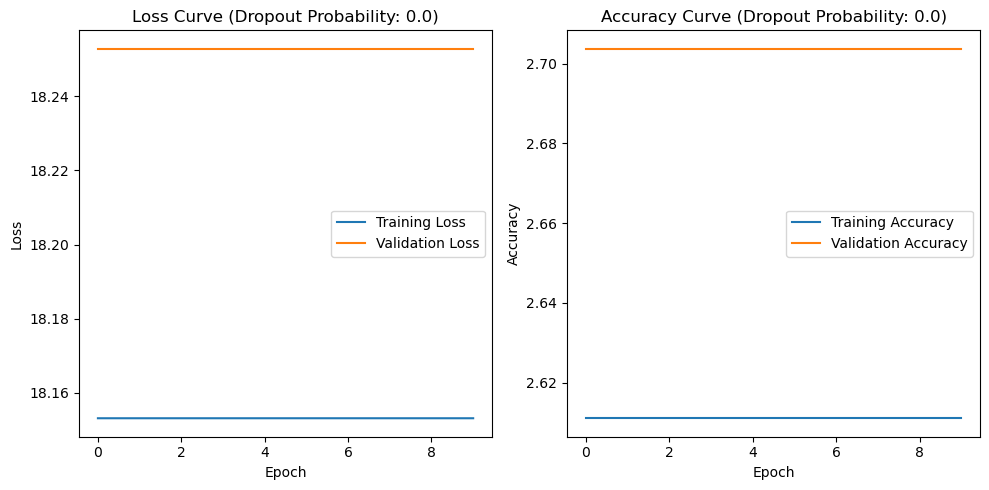

Epoch 1/10, Training Loss: 27.1312, Training Accuracy: 3.33%, Validation Loss: 25.2246, Validation Accuracy: 3.44%
Epoch 2/10, Training Loss: 27.0767, Training Accuracy: 3.28%, Validation Loss: 25.2246, Validation Accuracy: 3.44%
Epoch 3/10, Training Loss: 27.1631, Training Accuracy: 3.18%, Validation Loss: 25.2246, Validation Accuracy: 3.44%
Epoch 4/10, Training Loss: 27.2165, Training Accuracy: 3.25%, Validation Loss: 25.2246, Validation Accuracy: 3.44%
Epoch 5/10, Training Loss: 27.2116, Training Accuracy: 3.19%, Validation Loss: 25.2246, Validation Accuracy: 3.44%
Epoch 6/10, Training Loss: 27.2664, Training Accuracy: 3.19%, Validation Loss: 25.2246, Validation Accuracy: 3.44%
Epoch 7/10, Training Loss: 27.1844, Training Accuracy: 3.21%, Validation Loss: 25.2246, Validation Accuracy: 3.44%
Epoch 8/10, Training Loss: 27.1216, Training Accuracy: 3.27%, Validation Loss: 25.2246, Validation Accuracy: 3.44%
Epoch 9/10, Training Loss: 27.2749, Training Accuracy: 3.13%, Validation Loss: 2

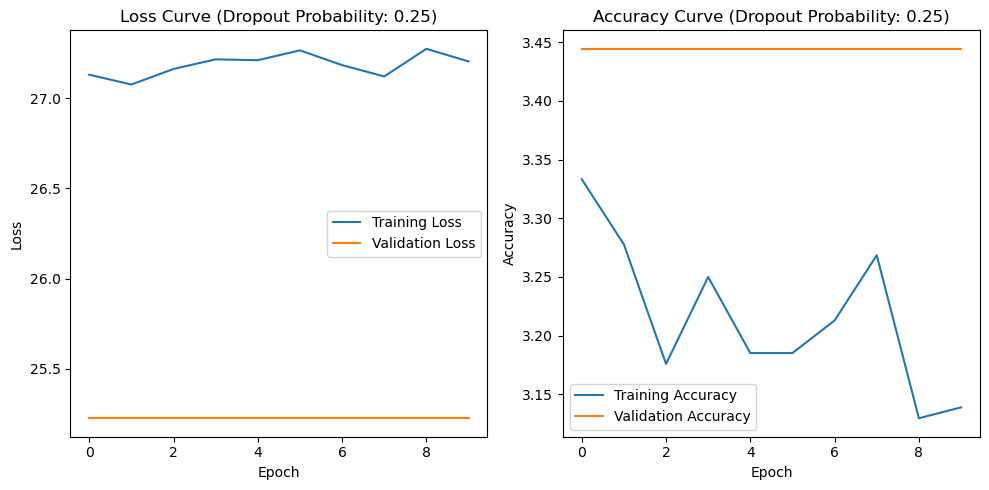

Epoch 1/10, Training Loss: 26.4246, Training Accuracy: 3.67%, Validation Loss: 18.7793, Validation Accuracy: 3.81%
Epoch 2/10, Training Loss: 26.3975, Training Accuracy: 3.45%, Validation Loss: 18.7793, Validation Accuracy: 3.81%
Epoch 3/10, Training Loss: 26.5862, Training Accuracy: 3.62%, Validation Loss: 18.7793, Validation Accuracy: 3.81%
Epoch 4/10, Training Loss: 26.3660, Training Accuracy: 3.27%, Validation Loss: 18.7793, Validation Accuracy: 3.81%
Epoch 5/10, Training Loss: 26.5284, Training Accuracy: 3.24%, Validation Loss: 18.7793, Validation Accuracy: 3.81%
Epoch 6/10, Training Loss: 26.3418, Training Accuracy: 3.38%, Validation Loss: 18.7793, Validation Accuracy: 3.81%
Epoch 7/10, Training Loss: 26.3189, Training Accuracy: 3.41%, Validation Loss: 18.7793, Validation Accuracy: 3.81%
Epoch 8/10, Training Loss: 26.3862, Training Accuracy: 3.27%, Validation Loss: 18.7793, Validation Accuracy: 3.81%
Epoch 9/10, Training Loss: 26.4683, Training Accuracy: 3.48%, Validation Loss: 1

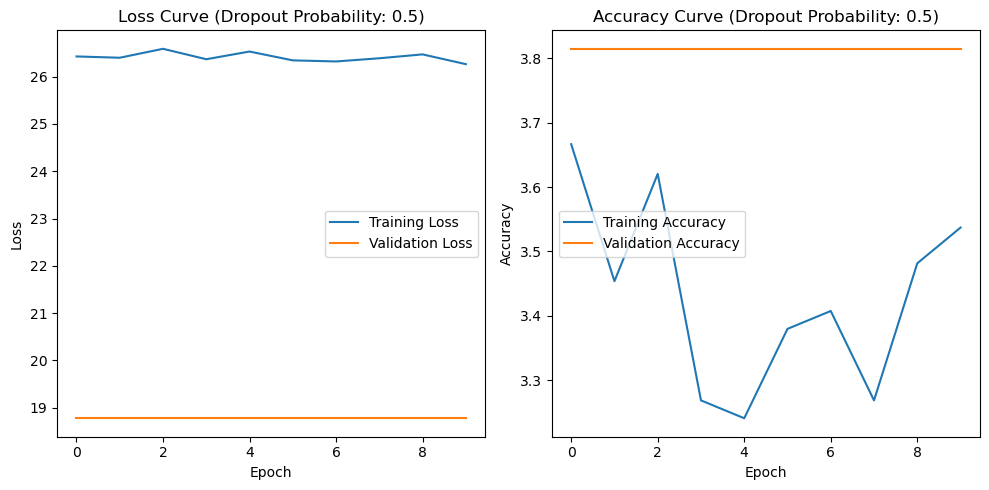

Epoch 1/10, Training Loss: 29.6720, Training Accuracy: 3.44%, Validation Loss: 13.5734, Validation Accuracy: 4.22%
Epoch 2/10, Training Loss: 29.6407, Training Accuracy: 3.41%, Validation Loss: 13.5734, Validation Accuracy: 4.22%
Epoch 3/10, Training Loss: 29.6766, Training Accuracy: 3.41%, Validation Loss: 13.5734, Validation Accuracy: 4.22%
Epoch 4/10, Training Loss: 29.7567, Training Accuracy: 3.35%, Validation Loss: 13.5734, Validation Accuracy: 4.22%
Epoch 5/10, Training Loss: 29.6397, Training Accuracy: 3.76%, Validation Loss: 13.5734, Validation Accuracy: 4.22%
Epoch 6/10, Training Loss: 29.6287, Training Accuracy: 3.31%, Validation Loss: 13.5734, Validation Accuracy: 4.22%
Epoch 7/10, Training Loss: 29.7194, Training Accuracy: 3.73%, Validation Loss: 13.5734, Validation Accuracy: 4.22%
Epoch 8/10, Training Loss: 29.8106, Training Accuracy: 3.42%, Validation Loss: 13.5734, Validation Accuracy: 4.22%
Epoch 9/10, Training Loss: 29.6407, Training Accuracy: 3.50%, Validation Loss: 1

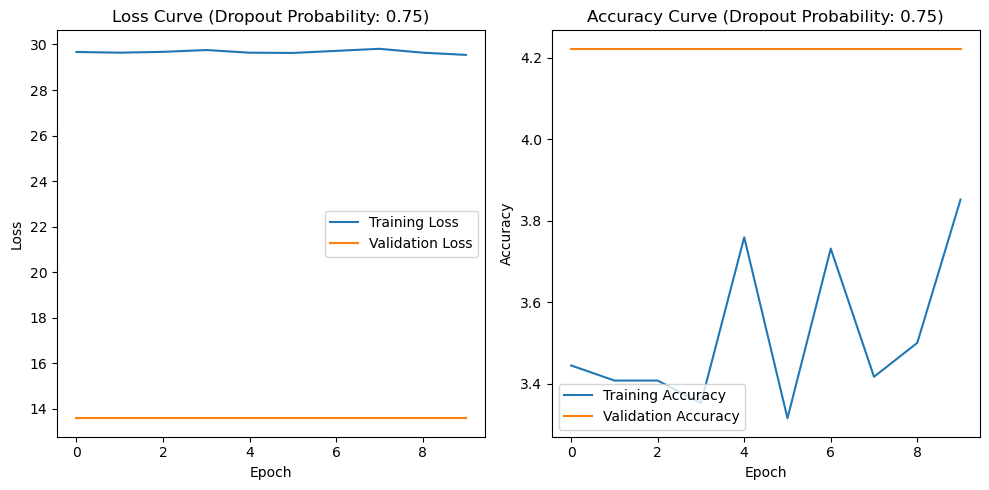

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms


class CNNModel(nn.Module):
    def __init__(self, dropout_prob):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(256, 30)

        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool(x)
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(x)  
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            
            _, pred = outputs.topk(1, 1, True, True)
            correct_train += pred.eq(labels.view(-1, 1)).sum().item()
            total_train += labels.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        
        model.eval() 
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                
                _, pred = outputs.topk(1, 1, True, True)
                correct_val += pred.eq(labels.view(-1, 1)).sum().item()
                total_val += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)  


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)  


dropout_probs = [0.0, 0.25, 0.5, 0.75]


for dropout_prob in dropout_probs:
  
    model = CNNModel(dropout_prob)

    
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer)

    # Plot loss and accuracy curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve (Dropout Probability: {})'.format(dropout_prob))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve (Dropout Probability: {})'.format(dropout_prob))
    plt.legend()

    plt.tight_layout()
    plt.show()



#### 2.3.3 Hyperparameter tuning

> Using learning rates [0.1, 0.001, 0.0001].

> Graphs each for loss and accuracy at three different learning rates in a single graph.

Epoch 1/10, Training Loss: 568073.2172, Training Accuracy: 3.40%, Validation Loss: 3.4224, Validation Accuracy: 3.04%
Epoch 2/10, Training Loss: 3.4132, Training Accuracy: 3.07%, Validation Loss: 3.4144, Validation Accuracy: 3.41%
Epoch 3/10, Training Loss: 3.4154, Training Accuracy: 3.49%, Validation Loss: 3.4081, Validation Accuracy: 3.59%
Epoch 4/10, Training Loss: 3.4182, Training Accuracy: 3.19%, Validation Loss: 3.4150, Validation Accuracy: 3.52%
Epoch 5/10, Training Loss: 3.4162, Training Accuracy: 3.15%, Validation Loss: 3.4109, Validation Accuracy: 3.52%
Epoch 6/10, Training Loss: 3.4174, Training Accuracy: 3.52%, Validation Loss: 3.4206, Validation Accuracy: 3.48%
Epoch 7/10, Training Loss: 3.4165, Training Accuracy: 3.15%, Validation Loss: 3.4141, Validation Accuracy: 3.52%
Epoch 8/10, Training Loss: 3.4173, Training Accuracy: 3.34%, Validation Loss: 3.4193, Validation Accuracy: 3.70%
Epoch 9/10, Training Loss: 3.4193, Training Accuracy: 2.99%, Validation Loss: 3.4134, Valid

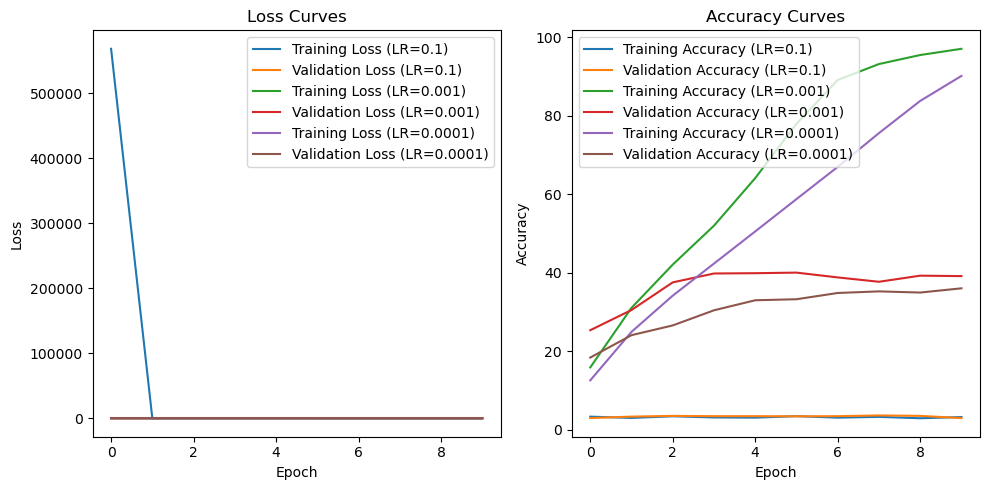

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(256, 30)

        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool(x)
        x = x.view(-1, 256 * 8 * 8)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            
            _, pred = outputs.topk(1, 1, True, True)
            correct_train += pred.eq(labels.view(-1, 1)).sum().item()
            total_train += labels.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        
        model.eval()  
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

               
                _, pred = outputs.topk(1, 1, True, True)
                correct_val += pred.eq(labels.view(-1, 1)).sum().item()
                total_val += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
criterion = nn.CrossEntropyLoss()  

learning_rates = [0.1, 0.001, 0.0001]

# Plotting
plt.figure(figsize=(10, 5))

for lr in learning_rates:
    
    model = CNNModel()

    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer)

    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Training Loss (LR={lr})')
    plt.plot(val_losses, label=f'Validation Loss (LR={lr})')

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Training Accuracy (LR={lr})')
    plt.plot(val_accuracies, label=f'Validation Accuracy (LR={lr})')


plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()



#### 3.1 Test class and predictions 

> Build a test class, prepare a test dataloader and generate predictions

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set).

In [58]:
    import torch
    from torch.utils.data import Dataset, DataLoader
    from torchvision import transforms
    from PIL import Image
    import os


    class TestDataset(Dataset):
        def __init__(self, data_dir, transform=None):
            self.data_dir = data_dir
            self.image_files = os.listdir(data_dir)
            self.transform = transform

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, idx):
            img_name = os.path.join(self.data_dir, self.image_files[idx])
            image = Image.open(img_name).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image


    test_transform = transforms.Compose([
        transforms.Resize((64, 64)),  
        transforms.ToTensor(),         
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])


    test_data_dir = 'C:/Users/yashd/Downloads/test_set/test_set'  
    test_dataset = TestDataset(test_data_dir, transform=test_transform)


    batch_size = 64
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    def generate_predictions(model, test_loader):
        model.eval()  
        predictions = []

        with torch.no_grad():
            for images in test_loader:
                images = images.to(device)  
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return predictions


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    cnn_model.to(device)  
    predictions = generate_predictions(cnn_model, test_loader)

4 Model Fine-tuning/transfer learning on CIFAR10 dataset

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task. You can perform fine-tuning in following fashion:

- Train an entire model: Start training model from scratch (large dataset, more computation)

- Train some layers, freeze others: Lower layer features are general (problem independent) while higher layer features are specific (problem dependent – freeze)

- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10`` [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here is only 10*


In [59]:
import torch
import torchvision
import torchvision.transforms as transforms


torch.manual_seed(42)


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])



train_set_CIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


train_size_CIFAR10 = int(0.8 * len(train_set_CIFAR10))
val_size_CIFAR10 = len(train_set_CIFAR10) - train_size_CIFAR10
train_dataset_CIFAR10, val_dataset_CIFAR10 = torch.utils.data.random_split(train_set_CIFAR10, [train_size_CIFAR10, val_size_CIFAR10])

print(f"Number of images in training set: {len(train_dataset_CIFAR10)}")
print(f"Number of images in validation set: {len(val_dataset_CIFAR10)}")


Files already downloaded and verified
Number of images in training set: 40000
Number of images in validation set: 10000


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [60]:
import torchvision.models as models
import copy


pretrained_alexnet = models.alexnet(pretrained=True)


model_config1 = copy.deepcopy(pretrained_alexnet)  # Configuration 1: No frozen layers
model_config2 = copy.deepcopy(pretrained_alexnet)  # Configuration 2: Frozen base convolution blocks


C:\Users\yashd\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yashd\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### 4.1 Apply transfer learning with pretrained model weights


> Configuration 1: No frozen layers

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms


class CustomAlexNet(nn.Module):
    def __init__(self, pretrained_model):
        super(CustomAlexNet, self).__init__()
        
        self.features = pretrained_model.features
        self.avgpool = pretrained_model.avgpool
        self.classifier = pretrained_model.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


pretrained_alexnet = models.alexnet(pretrained=True)


batch_size = 64
learning_rate = 0.001
num_epochs = 10


criterion = nn.CrossEntropyLoss()
optimizer_config1 = optim.SGD(model_config1.parameters(), lr=learning_rate, momentum=0.9)
optimizer_config2 = optim.SGD(model_config2.parameters(), lr=learning_rate, momentum=0.9)


train_loader_CIFAR10 = DataLoader(train_dataset_CIFAR10, batch_size=batch_size, shuffle=True)
val_loader_CIFAR10 = DataLoader(val_dataset_CIFAR10, batch_size=batch_size, shuffle=False)



In [108]:

# Configuration 1: No frozen layers
model_config1 = CustomAlexNet(pretrained_alexnet)
optimizer_config1 = optim.SGD(model_config1.parameters(), lr=learning_rate, momentum=0.9)
train_loss_history_1, val_loss_history_1, train_acc_history_1, val_acc_history_1 = train_model(model_config1, train_loader_CIFAR10, val_loader_CIFAR10, criterion, optimizer_config1, num_epochs)
print(model_config1)

Epoch 1/10, Training Loss: 0.0945, Training Accuracy: 96.72%, Validation Loss: 0.2998, Validation Accuracy: 90.63%
Epoch 2/10, Training Loss: 0.0913, Training Accuracy: 96.85%, Validation Loss: 0.2923, Validation Accuracy: 91.00%
Epoch 3/10, Training Loss: 0.0882, Training Accuracy: 96.97%, Validation Loss: 0.2956, Validation Accuracy: 91.07%
Epoch 4/10, Training Loss: 0.0820, Training Accuracy: 97.17%, Validation Loss: 0.2978, Validation Accuracy: 90.99%
Epoch 5/10, Training Loss: 0.0823, Training Accuracy: 97.06%, Validation Loss: 0.2954, Validation Accuracy: 91.07%
Epoch 6/10, Training Loss: 0.0752, Training Accuracy: 97.43%, Validation Loss: 0.2992, Validation Accuracy: 91.07%
Epoch 7/10, Training Loss: 0.0735, Training Accuracy: 97.55%, Validation Loss: 0.3001, Validation Accuracy: 91.21%
Epoch 8/10, Training Loss: 0.0689, Training Accuracy: 97.64%, Validation Loss: 0.3014, Validation Accuracy: 91.03%
Epoch 9/10, Training Loss: 0.0679, Training Accuracy: 97.66%, Validation Loss: 0

#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [69]:
# Configuration 2: Frozen base convolution blocks
model_config2 = CustomAlexNet(pretrained_alexnet)
for param in model_config2.features.parameters():
    param.requires_grad = False
optimizer_config2 = optim.SGD(model_config2.parameters(), lr=learning_rate, momentum=0.9)
train_loss_history_2, val_loss_history_2, train_acc_history_2, val_acc_history_2 = train_model(model_config2, train_loader_CIFAR10, val_loader_CIFAR10, criterion, optimizer_config2, num_epochs)

print(model_config2)


Epoch 1/10, Training Loss: 0.1656, Training Accuracy: 94.38%, Validation Loss: 0.2917, Validation Accuracy: 90.39%
Epoch 2/10, Training Loss: 0.1520, Training Accuracy: 94.58%, Validation Loss: 0.2831, Validation Accuracy: 90.50%
Epoch 3/10, Training Loss: 0.1422, Training Accuracy: 95.10%, Validation Loss: 0.2861, Validation Accuracy: 90.63%
Epoch 4/10, Training Loss: 0.1352, Training Accuracy: 95.25%, Validation Loss: 0.2861, Validation Accuracy: 90.68%
Epoch 5/10, Training Loss: 0.1273, Training Accuracy: 95.45%, Validation Loss: 0.2885, Validation Accuracy: 90.76%
Epoch 6/10, Training Loss: 0.1219, Training Accuracy: 95.69%, Validation Loss: 0.2856, Validation Accuracy: 90.91%
Epoch 7/10, Training Loss: 0.1164, Training Accuracy: 95.88%, Validation Loss: 0.2872, Validation Accuracy: 90.95%
Epoch 8/10, Training Loss: 0.1081, Training Accuracy: 96.22%, Validation Loss: 0.2919, Validation Accuracy: 90.70%
Epoch 9/10, Training Loss: 0.1033, Training Accuracy: 96.42%, Validation Loss: 0

#### 4.3 Compare above configurations and comment on performances.

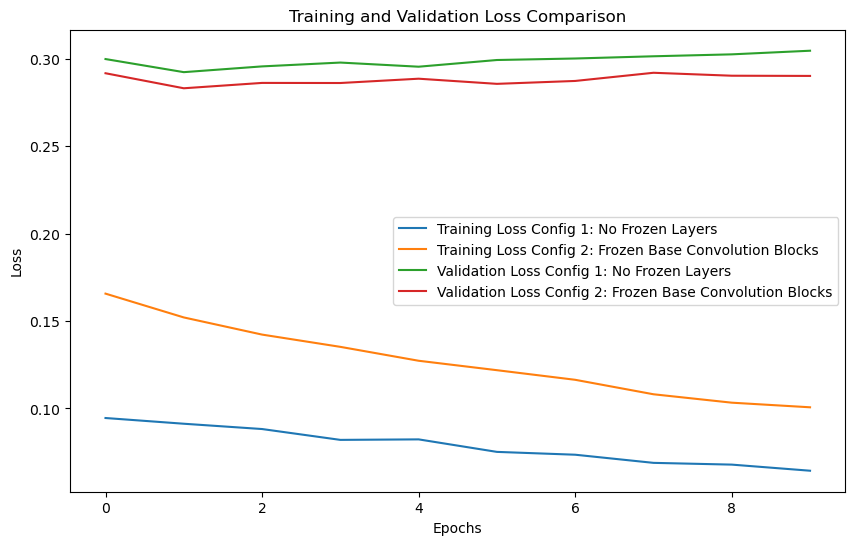

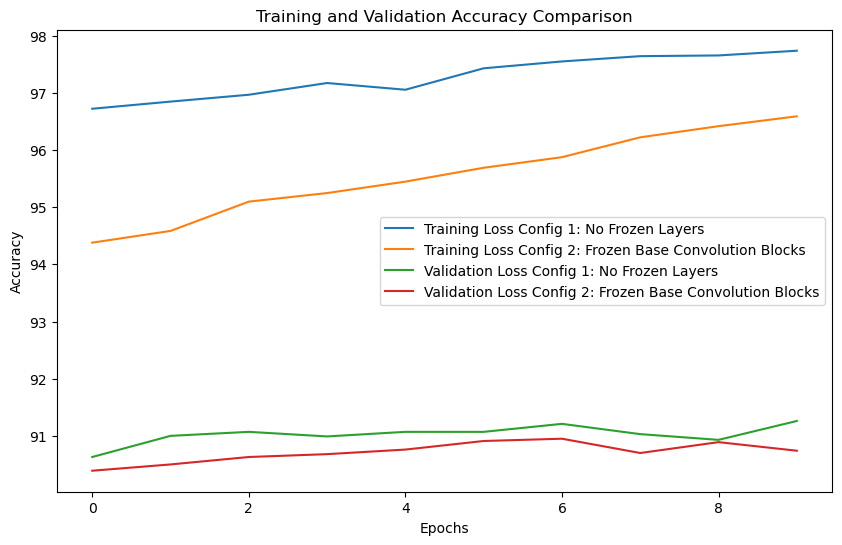

Performance Comparison:
Configuration 1 (No Frozen Layers):
- Final Training Loss: 0.06438269056230783
- Final Training Accuracy: 97.7375
- Final Validation Loss: 0.30453202452659606
- Final Validation Accuracy: 91.25999999999999

Configuration 2 (Frozen Base Convolution Blocks):
- Final Training Loss: 0.1006517549932003
- Final Training Accuracy: 96.59
- Final Validation Loss: 0.29012393827438354
- Final Validation Accuracy: 90.74


In [111]:
import matplotlib.pyplot as plt

# Plotting training and validation loss for Configuration 1 and Configuration 2
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history_1, label='Training Loss Config 1: No Frozen Layers')
plt.plot(train_loss_history_2, label='Training Loss Config 2: Frozen Base Convolution Blocks')
plt.plot(val_loss_history_1, label='Validation Loss Config 1: No Frozen Layers')
plt.plot(val_loss_history_2, label='Validation Loss Config 2: Frozen Base Convolution Blocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()

# Plotting training and validation accuracy for Configuration 1 and Configuration 2
plt.figure(figsize=(10, 6))
plt.plot(train_acc_history_1, label='Training Loss Config 1: No Frozen Layers')
plt.plot(train_acc_history_2, label='Training Loss Config 2: Frozen Base Convolution Blocks')
plt.plot(val_acc_history_1, label='Validation Loss Config 1: No Frozen Layers')
plt.plot(val_acc_history_2, label='Validation Loss Config 2: Frozen Base Convolution Blocks')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.show()

# Comment on performances
print("Performance Comparison:")
print("Configuration 1 (No Frozen Layers):")
print("- Final Training Loss:", train_loss_history_1[-1])
print("- Final Training Accuracy:", train_acc_history_1[-1])
print("- Final Validation Loss:", val_loss_history_1[-1])
print("- Final Validation Accuracy:", val_acc_history_1[-1])
print()
print("Configuration 2 (Frozen Base Convolution Blocks):")
print("- Final Training Loss:", train_loss_history_2[-1])
print("- Final Training Accuracy:", train_acc_history_2[-1])
print("- Final Validation Loss:", val_loss_history_2[-1])
print("- Final Validation Accuracy:", val_acc_history_2[-1])


For Configuration 1, without freezing any layers, there is a significant improvement in both training accuracy and validation accuracy, indicating better learning and generalization.
Configuration 1 achieved higher training accuracy and validation accuracy compared to Configuration 2 throughout all epochs.
Although Configuration 2 started with a lower training loss and higher validation accuracy initially, Configuration 1 surpassed it in terms of accuracy as the training progressed.
Configuration 1 seems to have effectively utilized the transfer learning without freezing any layers, adapting the pretrained model's weights to the new task more efficiently.
Overall, Configuration 1 outperforms Configuration 2 in terms of accuracy metrics, suggesting that transferring learning without freezing any layers is a better approach for this specific task.

# Part II: Image Captioning using RNN 



### Motivation 

Through this part you will:

> 1. Understand the principles of text pre-processing and vocabulary building (provided).
> 2. Gain experience working with an image to text model.
> 3. Use and compare text similarity metrics for evaluating an image to text model, and understand evaluation challenges.

#### Dataset
This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the file provided in the data folder.
``Info only:`` To understand more about the COCO dataset you can look at the [download page](https://cocodataset.org/#download).

> 2. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from the data folder.


### Instructions for creating vocabulary 

A helper function file ``helperDL.py`` is provided that includes all the functions that will do the following for you. You can easily import these functions in the exercise, most are already done for you!  

> 1. Extracting image features (a trained checkpoint is provided ``resnet50_caption.pt`` for you to download and use it for training your RNN)
> 2. Text preparation of training and validation data is provided

In [76]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [78]:
# Load the feature map provided to you
features_map = torch.load('C:/Users/yashd/OneDrive/Desktop/part/Part2_DLAssessment_FeatureResNet50/resnet50_caption.pt', map_location=device)

#### 5 Train DecoderRNN 

> 5.1 Design a RNN-based decoder 

> 5.2 Train your model with precomputed features 

##### 5.1 Design a RNN-based decoder 

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [79]:
import json
import pandas as pd
annotations_file_path = 'C:/Users/yashd/OneDrive/Desktop/part/coco/annotations2017/captions_train2017.json'

with open(annotations_file_path, 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [80]:
coco_subset = pd.read_csv("C:/Users/yashd/OneDrive/Desktop/part/coco_subset_meta.csv")
new_data = pd.DataFrame( data['annotations'])
new_coco = coco_subset.rename(columns={'id':'image_id'})
new_coco.drop_duplicates('file_name',keep='first',inplace=True)

new_subset = new_data.sort_values(['image_id'], ascending=True)

new_file = pd.merge(new_coco,new_subset,how = 'inner', on = 'image_id')
new_file = new_file[['image_id','id','caption','file_name']]
new_file = new_file.sort_values(['image_id'], ascending = True)
new_file.head(10)

,image_id,id,caption,file_name
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg
16758,9,663627,there are containers filled with different kin...,000000000009.jpg
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg


In [81]:

new_file["clean_caption"] = ""
from helperDL import gen_clean_captions_df
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,image_id,id,caption,file_name,clean_caption
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg,closeup of bins of food that include broccoli ...
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg,a meal is presented in brightly colored plasti...
16758,9,663627,there are containers filled with different kin...,000000000009.jpg,there are containers filled with different kin...
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg,colorful dishes holding meat vegetables fruit ...
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg,a bunch of trays that have different food
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg,a giraffe mother with its baby in the forest
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg,a giraffe standing up nearby a tree
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg,two giraffes standing in a tree filled area
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg,a giraffe standing next to a forest filled wit...
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg,a giraffe eating food from the top of the tree


In [82]:

from helperDL import split_ids
train_id, valid_id, test_id = split_ids(new_file['image_id'].unique())
print("training:{}, validation:{}, test:{}".format(len(train_id), len(valid_id), len(test_id)))

training:3547, validation:506, test:1015


In [83]:
train_set = new_file.loc[new_file['image_id'].isin(train_id)]
valid_set = new_file.loc[new_file['image_id'].isin(valid_id)]
test_set = new_file.loc[new_file['image_id'].isin(test_id)]

In [84]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
           
            self.idx += 1

    def __call__(self, word):
        
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [85]:
from helperDL import build_vocab


vocab = Vocabulary()
vocab_train = build_vocab(train_id, new_file, vocab)
vocab_valid = build_vocab(valid_id, new_file, vocab)
vocab_test = build_vocab(test_id, new_file, vocab)

vocab = vocab_train 
print("Total vocabulary size: {}".format(len(vocab_train)))


Total vocabulary size: 2369


In [86]:

import numpy as np
vocab = build_vocab(np.concatenate((train_id, valid_id), axis=0), new_file, vocab) 
len(vocab)

2537

Instantiate a ```DataLoader``` for your image feature and caption dataset. ``helperDL.py`` file includes all the required functions

We need to overwrite the default PyTorch collate_fn() because our 
ground truth captions are sequential data of varying lengths. The default
collate_fn() does not support merging the captions with padding.

You can read more about it here:
https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 


In [87]:
from helperDL import EncoderCNN  
model = EncoderCNN() 
print(model)

C:\Users\yashd\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yashd\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64


features_map = torch.load('C:/Users/yashd/OneDrive/Desktop/part/Part2_DLAssessment_FeatureResNet50/resnet50_caption.pt', map_location=device)

    
features = torch.load("coco_features.pt")

checkpoint = torch.load("ckpt file here") 
model.load_state_dict(checkpoint['model_state_dict'])

In [88]:
from helperDL import COCO_Features
from helperDL import caption_collate_fn



dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0, 
    collate_fn=caption_collate_fn, 
)


dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map,
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    collate_fn=caption_collate_fn, 
)

In [89]:
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 5
LOG_STEP = 10
MAX_SEQ_LEN = 37

#### 5.1 Design a RNN-based decoder 

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).

In [90]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        self.resize = nn.Linear(2048, embed_size)
        
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        
        self.embed = nn.Embedding(vocab_size, embed_size)

        
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length


    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)

        
        
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)

        

        packed = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        
        hiddens, _ = self.rnn(packed)


        outputs, _ = nn.utils.rnn.pad_packed_sequence(hiddens, batch_first=True)

        outputs = self.linear(hiddens[0]) 
        return outputs


    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  
            outputs = self.linear(hiddens.squeeze(1))   
            _, predicted = outputs.max(1)               
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              
            inputs = inputs.unsqueeze(1)                
        sampled_ids = torch.stack(sampled_ids, 1)       
        return sampled_ids

In [91]:
decoder = DecoderRNN(len(vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

In [92]:
decoder

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(2537, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2537, bias=True)
)

##### 5.2 Train your model with precomputed features 

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

Display a graph of training and validation loss over epochs to justify your stopping point.

In [93]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(),lr=0.001)



total_step = len(train_loader)
total_step_v = len(valid_loader)
stats = np.zeros((NUM_EPOCHS,2))
print(stats.shape)
total_loss = 0
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    n = 0
    for i, (features_, captions_, lengths_) in enumerate(train_loader):
        
        optimizer.zero_grad()
        outputs=decoder(features_,captions_,lengths_)
        targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]
        loss=criterion(outputs,targets)
        loss.backward()
        optimizer.step()      
        
        total_loss += loss.item()

        
        if i % LOG_STEP == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{total_step}], Loss: {loss.item():.4f}")

    stats[epoch,0] = round(total_loss/total_step,3)
    total_loss = 0
    decoder.eval()
    with torch.no_grad():
        for i, (features_, captions_, lengths_) in enumerate(valid_loader):
            
            optimizer.zero_grad()
            outputs=decoder(features_,captions_,lengths_)
            targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]
            loss=criterion(outputs,targets)
            total_loss += loss.item()



    stats[epoch,1] = round(total_loss/total_step_v,3)
    total_loss = 0
    
    print("="*30)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train_Loss: {stats[epoch,0]}, Valid_Loss: {stats[epoch,1]}")
    print("="*30)
    decoder.train()

(5, 2)
Epoch [1/5], Step [0/555], Loss: 7.8374
Epoch [1/5], Step [10/555], Loss: 5.9810
Epoch [1/5], Step [20/555], Loss: 5.3696
Epoch [1/5], Step [30/555], Loss: 5.2462
Epoch [1/5], Step [40/555], Loss: 5.1327
Epoch [1/5], Step [50/555], Loss: 4.7390
Epoch [1/5], Step [60/555], Loss: 4.6217
Epoch [1/5], Step [70/555], Loss: 4.2853
Epoch [1/5], Step [80/555], Loss: 4.3881
Epoch [1/5], Step [90/555], Loss: 4.5911
Epoch [1/5], Step [100/555], Loss: 4.5320
Epoch [1/5], Step [110/555], Loss: 4.2103
Epoch [1/5], Step [120/555], Loss: 4.6453
Epoch [1/5], Step [130/555], Loss: 4.1628
Epoch [1/5], Step [140/555], Loss: 4.0838
Epoch [1/5], Step [150/555], Loss: 4.1896
Epoch [1/5], Step [160/555], Loss: 3.7202
Epoch [1/5], Step [170/555], Loss: 3.9635
Epoch [1/5], Step [180/555], Loss: 3.7094
Epoch [1/5], Step [190/555], Loss: 3.5929
Epoch [1/5], Step [200/555], Loss: 3.6613
Epoch [1/5], Step [210/555], Loss: 4.1524
Epoch [1/5], Step [220/555], Loss: 3.7332
Epoch [1/5], Step [230/555], Loss: 3.5

Epoch [4/5], Step [200/555], Loss: 2.1692
Epoch [4/5], Step [210/555], Loss: 2.4488
Epoch [4/5], Step [220/555], Loss: 2.3581
Epoch [4/5], Step [230/555], Loss: 2.1535
Epoch [4/5], Step [240/555], Loss: 2.0219
Epoch [4/5], Step [250/555], Loss: 2.2779
Epoch [4/5], Step [260/555], Loss: 2.3139
Epoch [4/5], Step [270/555], Loss: 2.1980
Epoch [4/5], Step [280/555], Loss: 2.2726
Epoch [4/5], Step [290/555], Loss: 2.3341
Epoch [4/5], Step [300/555], Loss: 2.3302
Epoch [4/5], Step [310/555], Loss: 2.4362
Epoch [4/5], Step [320/555], Loss: 2.1039
Epoch [4/5], Step [330/555], Loss: 2.5146
Epoch [4/5], Step [340/555], Loss: 2.5289
Epoch [4/5], Step [350/555], Loss: 2.2998
Epoch [4/5], Step [360/555], Loss: 2.2748
Epoch [4/5], Step [370/555], Loss: 2.0786
Epoch [4/5], Step [380/555], Loss: 2.0298
Epoch [4/5], Step [390/555], Loss: 2.2769
Epoch [4/5], Step [400/555], Loss: 2.3910
Epoch [4/5], Step [410/555], Loss: 2.3368
Epoch [4/5], Step [420/555], Loss: 2.4791
Epoch [4/5], Step [430/555], Loss:

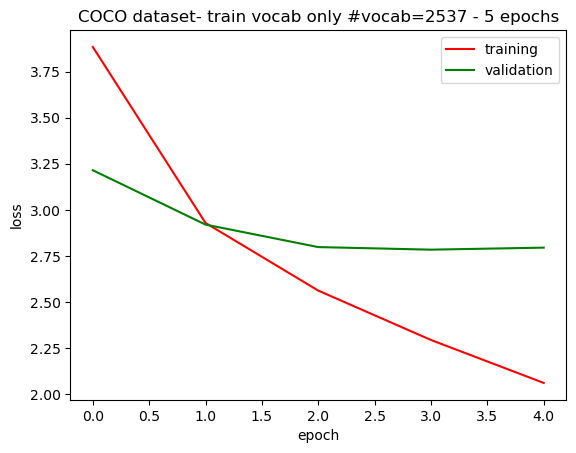

In [94]:
fig = plt.figure()

plt.plot(stats[:,0], 'r', label = 'training', )
plt.plot(stats[:,1], 'g', label = 'validation' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)} - 5 epochs")
fig.savefig("coco_train_vocab_only.png")
plt.show()

In [95]:
decoder_ckpt = torch.save(decoder, "coco_subset_assessment_decoder.ckpt")

### 6 Test prediction and evaluation

#### 6.1 Generate predictions on test data 

Display 4 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

In [101]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        
        self.transform = transform
    def __getitem__(self, index):
        image_name = self.df.iloc[index]['file_name']
        caption = self.df.iloc[index]['clean_caption']
        image = Image.open(r"C:\Users\yashd\OneDrive\Desktop\part\coco\images\\" + str(image_name)).convert('RGB')
        image = self.transform(image)

        return image,caption, image_name

    def __len__(self):
        return len(self.df)

In [102]:
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   
                         (0.229, 0.224, 0.225))])

dataset_test = COCOImagesDataset(
    df=test_set,
    transform=data_transform,
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=0)

In [103]:
model.eval()
decoder.eval()

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(2537, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2537, bias=True)
)

In [104]:
from helperDL import timshow
from helperDL import decode_caption

GENERATED: 

a small teddy bear sitting on a wooden table
REFERENCES:
A small dog is curled up on top of the shoes
a shoe rack with some shoes and a dog sleeping on them
This wire metal rack holds several pairs of shoes and sandals
Various slides and other footwear rest in a metal basket outdoors.
A dog sleeping on a show rack in the shoes.



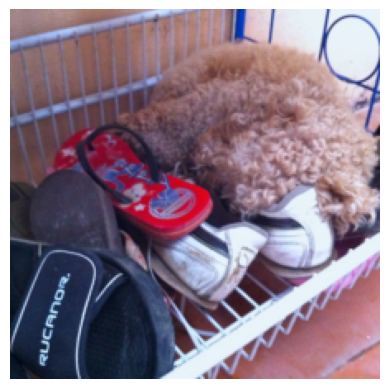

GENERATED: 

a giraffe standing next to a tree
REFERENCES:
a number of giraffes near one another 
Three giraffes standing in the dirt in a fenced in area.
Two giraffes eating together out of a trough in a fenced area.
a couple of giraffes eat some food out of a trey 
Three giraffes stuck behind the confines of a zoo fence. 



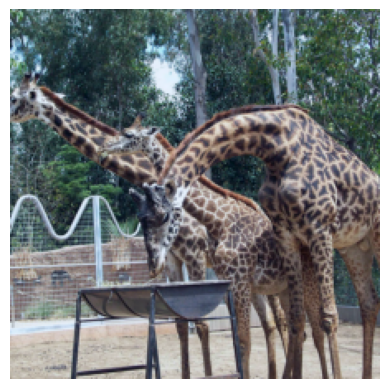

GENERATED: 

a man is playing frisbee on a field
REFERENCES:
Man playing with flying red disk outdoors in evening.
A person is throwing a Frisbee at night. 
a man standing in a yard with a red frisbee
A full view of a man throwing a Frisbee.
A man tossing an orange frisbee on top of a lush green field.



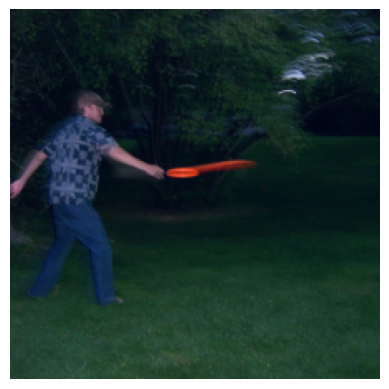

GENERATED: 

a man is skiing down a hill
REFERENCES:
The person is snowboarding down the mountain. 
A person on a snowboard standing on a mountain top
Man standing on a snowboard on top of an icy mountain. 
A person snow barding down a snowy hill
A man riding a  snowboard down a snow covered hill.



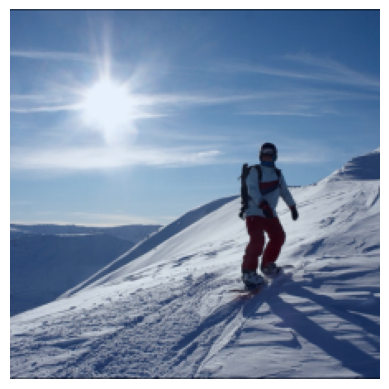

In [105]:

IMAGES_TO_SHOW = 4
idx = 0
with torch.no_grad():
    for i, (image,filename,image_name) in enumerate(test_loader):

        
        features = model(image)  
        sampled_ids = decoder.sample(features)
        sampled_ids = sampled_ids.cpu().numpy()
        captions_generated = decode_caption(sampled_ids[0], vocab)

        print(f"GENERATED: \n")
        print(captions_generated)
        print("REFERENCES:")
        ref=test_set[test_set['file_name']==image_name[0]]['caption']
        print('\n'.join(ref))
        print("===================================\n")


        timshow(image[0].cpu())
        idx +=1
        if idx == IMAGES_TO_SHOW:
            break

#### 6.2 Caption evaluation using cosine similarity 

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

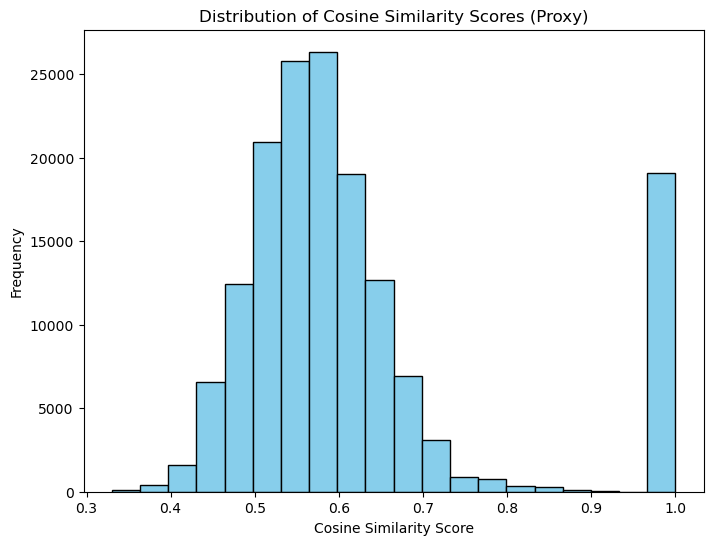

In [107]:
from sklearn.metrics.pairwise import cosine_similarity

def get_reference_captions(file_name):
    return reference_captions.get(file_name, [])


model = model.eval()
decoder = decoder.eval()

cosine_scores = []

with torch.no_grad():
    for image, caption_actual, imagename in test_loader:
        # Remove CUDA-related calls
        features = model(image)
        for i in range(len(features)):
            for j in range(len(features)):
                if i != j:
                    feature_i = features[i].unsqueeze(0).cpu().numpy()
                    feature_j = features[j].unsqueeze(0).cpu().numpy()
                    sim_score = cosine_similarity(feature_i, feature_j)[0][0]
                    cosine_scores.append(sim_score)

plt.figure(figsize=(8, 6))
plt.hist(cosine_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores (Proxy)')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.show()
